# Word2Vec Implementation

In [64]:
from preprocess_email import ham_df,spam_df, combined_df
import nltk
import numpy as np
import seaborn as sns
import pandas as pd

In [65]:
values = combined_df['Label'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100 #ham
percentage_1 = (values[1]/ total) *100 #spam

print('percentage of ham :' ,percentage_0)
print('percentage of spam :' ,percentage_1)

percentage of ham : 56.869918699187
percentage of spam : 43.130081300813


In [66]:
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))



nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()



import string

def process_text(content):
    filtered_list = []
    remove_punc = []
    content = content.lower()
    content = word_tokenize(content)
    for word in content:
        remove_punc = [word for word in content if word not in string.punctuation] # remove punctuation
    
    content = remove_punc
    
    # remove_punc.clear()
    
    for word in content:
        if word.casefold() not in stop_words:
            filtered_list.append(word)

    
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_list]
    # stemmed_words = [stemmer.stem(word) for word in filtered_list]
    content.clear()
    remove_punc.clear()
    
    return ' '.join(lemmatized_words)
    # return ' '.join(stemmed_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
combined_df['processed_text'] = combined_df['Main_Content'].apply(process_text)
print(combined_df.shape)
combined_df.describe()

(2460, 3)


,Label
count,2460.000000
mean,0.431301
std,0.495359
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [68]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

combined_df['processed_text'] = combined_df['processed_text'].apply(gensim.utils.simple_preprocess)

print(combined_df['processed_text'])

0       [date, wed, aug, exmh, contenttype, textplain,...
1       [robert, elz, date, wed, aug, date, tue, aug, ...
2       [ouchill, get, right, robert, elz, date, wed, ...
3       [wed, aug, robert, elz, said, hmm, ive, using,...
4       [chris, garrigues, date, wed, aug, ouchill, ge...
                              ...                        
2455    [long, time, chathow, youve, like, youve, tryi...
2456    [result, feedback, form, submitted, thursday, ...
2457    [america, top, company, compete, business, win...
2458    [want, watch, hardcore, porn, movie, site, vot...
2459    [dear, cypherpunks, email, email, emailemail, ...
Name: processed_text, Length: 2460, dtype: object


In [69]:
word2vec = Word2Vec(sentences=combined_df['processed_text'], vector_size=300, window=6, min_count=2, workers=4, epochs=20, sg=1, hs=0)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

X = averaged_word_vectorizer(combined_df['processed_text'], word2vec, 300)
# print(X)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, combined_df['Label'], test_size=0.2, random_state=42)

LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)

LR_accuracy = accuracy_score(y_test, y_pred)
LR_precision = precision_score(y_test, y_pred)
print("Accuracy:", LR_accuracy)
print("Precision:", LR_precision)

Accuracy: 0.9857723577235772
Precision: 0.9759615384615384


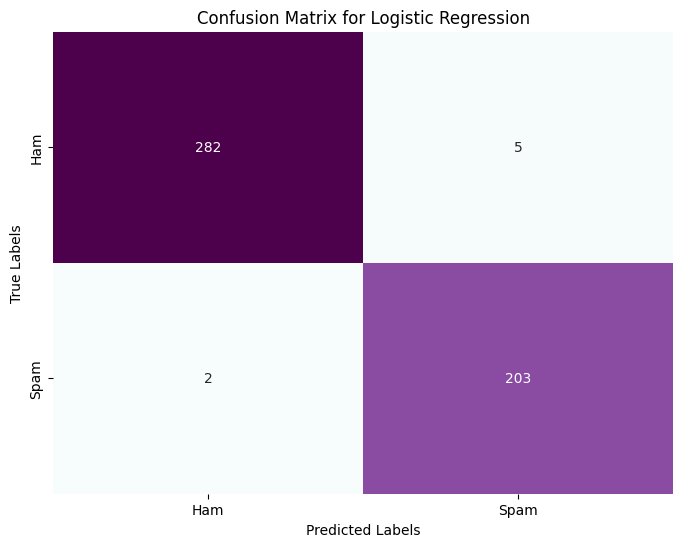

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="BuPu", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')

plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])


plt.show()

In [72]:
from sklearn.naive_bayes import GaussianNB  # multinomial NB can't handle negative values generated by word2vec

NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

# Predict on test data
y_pred = NB_model.predict(X_test)
# Evaluate model
NB_accuracy = accuracy_score(y_test, y_pred)
NB_precision = precision_score(y_test, y_pred)
print("Accuracy:", NB_accuracy)
print("Precision:", NB_precision)

Accuracy: 0.9654471544715447
Precision: 0.9563106796116505


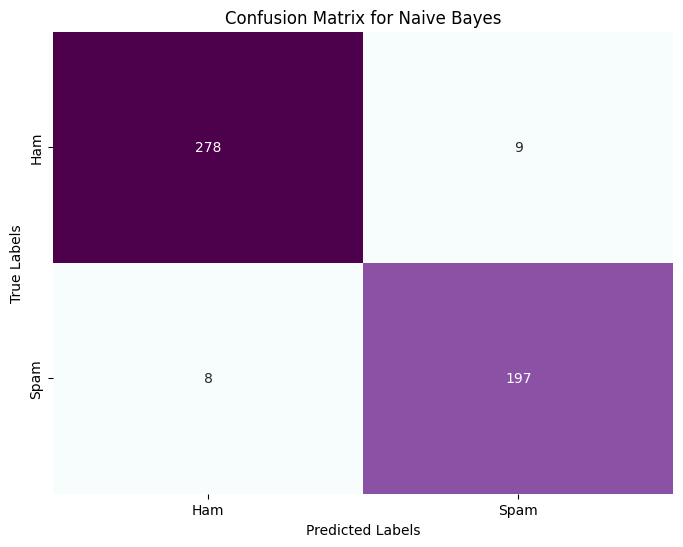

In [73]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="BuPu", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes')

plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])  
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])  


plt.show()

In [74]:
from sklearn.svm import SVC

num_features = X_train.shape[1]
SVM = SVC()
SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

SVM_accuracy = accuracy_score(y_test, y_pred)
SVM_precision = precision_score(y_test, y_pred)
print("Accuracy:", SVM_accuracy)
print("Precision:", SVM_precision)

Accuracy: 0.991869918699187
Precision: 0.9902439024390244


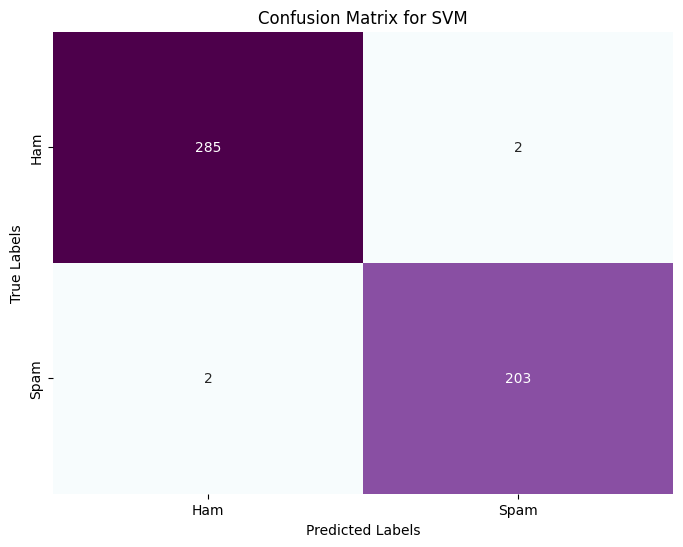

In [75]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="BuPu", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')

plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])


plt.show()

In [76]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(max_depth = 26)
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)

DT_accuracy = accuracy_score(y_test, y_pred)
DT_precision = precision_score(y_test, y_pred)
print("Accuracy:", DT_accuracy)
print("Precision:", DT_precision)

Accuracy: 0.9308943089430894
Precision: 0.9052132701421801


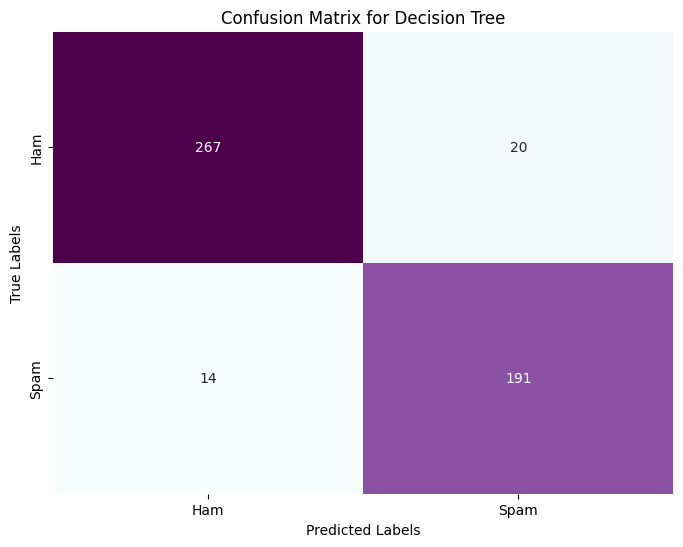

In [77]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="BuPu", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree')

plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])


plt.show()

In [78]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

KNN_accuracy = accuracy_score(y_test, y_pred)
KNN_precision = precision_score(y_test, y_pred)
print("Accuracy:", KNN_accuracy)
print("Precision:", KNN_precision)

Accuracy: 0.9857723577235772
Precision: 0.995


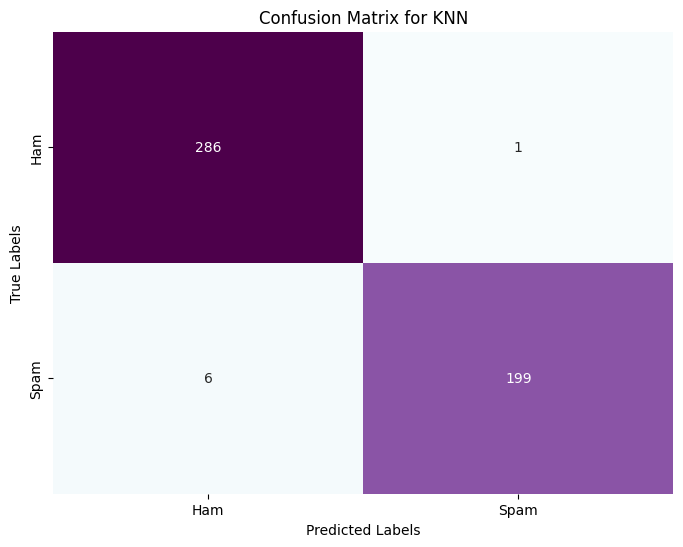

In [79]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="BuPu", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN')

plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])


plt.show()

In [80]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators = 200, random_state = 5 )
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

RF_accuracy = accuracy_score(y_test, y_pred)
RF_precision = precision_score(y_test, y_pred)
print("Accuracy:", RF_accuracy)
print("Precision:", RF_precision)

Accuracy: 0.9857723577235772
Precision: 0.9900990099009901


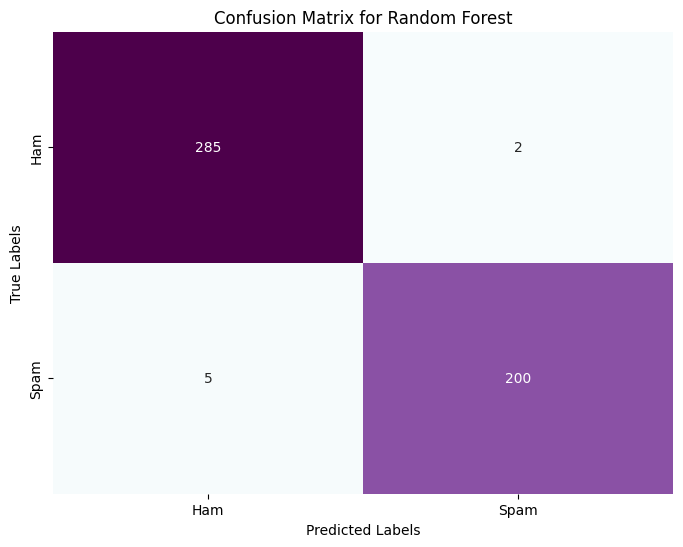

In [81]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="BuPu", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')

plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])


plt.show()

# Comparison Between Models

In [82]:
model_table = [
    {'Model': 'Logistic Regression', 'Accuracy': LR_accuracy, 'Precision': LR_precision},
    {'Model': 'Naive Bayes', 'Accuracy': NB_accuracy, 'Precision': NB_precision},
    {'Model': 'SVM', 'Accuracy': SVM_accuracy, 'Precision': SVM_precision},
    {'Model': 'Decision Tree', 'Accuracy': DT_accuracy, 'Precision': DT_precision},
    {'Model': 'KNN', 'Accuracy': KNN_accuracy, 'Precision': KNN_precision},
    {'Model': 'Random Forest', 'Accuracy': RF_accuracy, 'Precision': RF_precision},
]

# Convert the data to a DataFrame
df = pd.DataFrame(model_table)


# Sort the DataFrame by both Accuracy and Precision scores
sorted_df = df.sort_values(by=['Accuracy', 'Precision'], ascending=[False, False])
sorted_df.reset_index(drop=True, inplace=True)

sorted_df.index = range(1, len(df) + 1)
sorted_df


,Model,Accuracy,Precision
1,SVM,0.991870,0.990244
2,KNN,0.985772,0.995000
3,Random Forest,0.985772,0.990099
4,Logistic Regression,0.985772,0.975962
5,Naive Bayes,0.965447,0.956311
6,Decision Tree,0.930894,0.905213


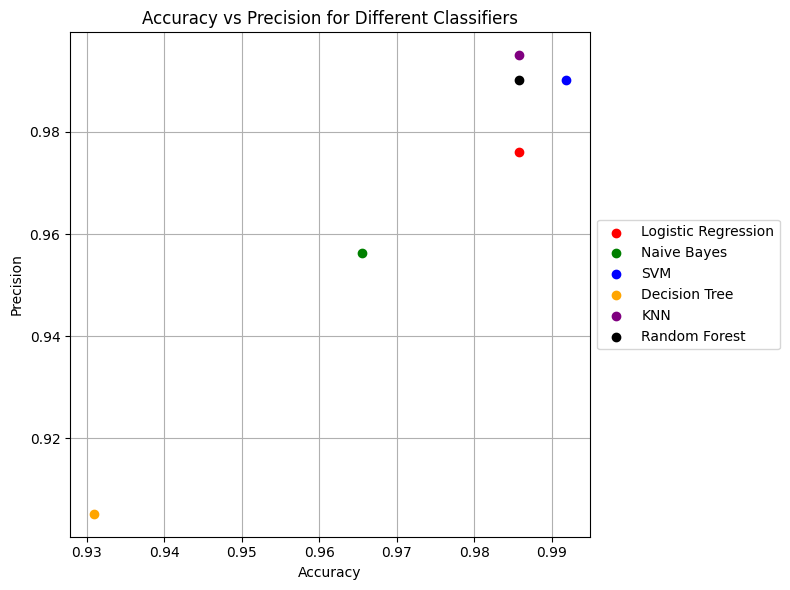

In [83]:
import matplotlib.pyplot as plt

# Extract accuracy and precision values
accuracy_values = df['Accuracy']
precision_values = df['Precision']
model_names = df['Model']


model_colors = {
    'Logistic Regression': 'red',
    'SVM': 'blue',
    'Naive Bayes': 'green',
    'Decision Tree': 'orange',
    'KNN': 'purple',
    'Random Forest': 'black'
}

# Create scatter plot with color coding based on model names
plt.figure(figsize=(8, 6))
for idx, model in enumerate(model_names):
    acc = accuracy_values[idx]
    prec = precision_values[idx]
    color = model_colors.get(model)
    plt.scatter(acc, prec, color=color, label=model)

# Add labels and title
plt.xlabel('Accuracy')
plt.ylabel('Precision')
plt.title('Accuracy vs Precision for Different Classifiers')

# Create legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Save Top 3 Models

In [85]:
import joblib

joblib.dump(RF, 'W2V_RF.joblib')
joblib.dump(SVM, 'W2V_SVM.joblib')
joblib.dump(LR, 'W2V_LR.joblib')

word2vec.save('word2vec.bin')